In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt


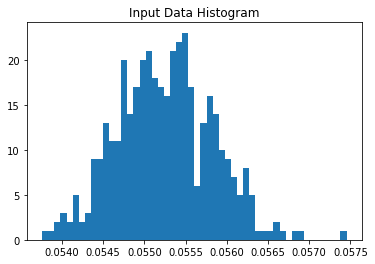

31


In [2]:
Nmeas = 400
filelist= ["./B6664andB7280EuclideanCorrelatorsCharmoniumT0/B6664/Mc32x32_30."+ str(k)  for k in range(1,Nmeas+1)];
RawCorrelators = [np.loadtxt(f, skiprows=0) for f in filelist]
#print(RawCorrelators[4])


#stacks all the elements of measurement point k into a single array, correct interpretation? 
DataArrayIndiv=np.column_stack(RawCorrelators[k][1:,2] for k in range(Nmeas))


#Histogram of the data from a single measurement point in this case 1
F01=plt.figure()
plt.yscale('linear')
plt.title('Input Data Histogram')
plt.hist(DataArrayIndiv[1],bins=50);
plt.show()


DataAverage=np.average(DataArrayIndiv,axis=1)
print(len(DataAverage))


In [3]:
#Kernel definition
Nw=1000;
Nt = 31;

wmin=0.0001;
wmax=6.;
dw=(wmax-wmin)/Nw;
Frequencies = np.array([wmin+dw*w for w in range(Nw)])


#Trapezoidal rule
Kernel=np.array([[  (1./2. if w == 0 or w== Nw-1 else 1.) * 
                    dw*np.exp(-Frequencies[w]*t) 
                  for w in range(Nw) ] for t in range(1,Nt+1)]);
print(Kernel.shape)



(31, 1000)


In [4]:
def Q(b,*args):
    data=args[0]
    kernel = args[1]
    sigma = args[2]
    dw = args[3]
    alpha = args[4]
    m = args[5]
    
    rho = np.exp(b)
    
    rhodat = kernel@rho
    
    Nrho = len(rho)
    
    S=0;
    L=0;    
    
    #distance
    for i in range(len(data)):
        L+=0.5*((data[i]-rhodat[i])/sigma[i])**2
    
    #cost function
    for j in range(Nrho):
         S+=(0.5 if j == 0 or j== Nrho-1 else 1.)*(1.-rho[j]/m+np.log(rho[j]/m))*dw*alpha
         #print(S)
    #combined
    q=L-S
   
    return q

def QDer(b, *args):
    data=args[0]
    kernel = args[1]
    sigma = args[2]
    dw = args[3]
    alpha = args[4]
    m = args[5]
    
    
    rho = np.exp(b)
    
    rhodat = kernel@rho
    
    Nrho = len(rho)
    
    gradient=[0]*len(rho)
    
    
    for j in range(len(rho)):
        
        
        dwc = (0.5 if j == 0 or j== Nrho-1 else 1.)*dw
        
        tmp=0;
        
        #first finding the derivative for the "L" part
        for i in range(len(data)):
            tmp +=((data[i]-rhodat[i]))/(sigma[i]**(2))*(-kernel[i,j]*rho[j])
        
        #S derivative
        SDer =(-rho[j]/m+1.)*dwc*alpha
        
        #Combining the derivative from L and S
        gradient[j]=(tmp-SDer)
        
    return np.asarray(gradient)


In [5]:
def Reconstruct(*args):
    data=args[0] #Measured data
    kernel = args[1]
    dw = args[2]
    alpha = args[3]
    m = args[4]
    
    Nmu = len(data)
    Nmeas = len(data[1,])
    
    Nw = len(Kernel[1,])
    
    DataAverage = np.empty(Nmu)


    for j in range(len(data)):
        DataAverage[j]=np.mean(data[j,])
    
    AutoCorrelationCorr=4.; 


    DataCovarianceMatrix=AutoCorrelationCorr*np.array([[ sum( np.array([ ( data[i,n]-DataAverage[i] )*
                                     ( data[j,n]-DataAverage[j] )/((Nmeas-1.)*Nmeas) for n in range(Nmeas)]) )
                  for i in range(Nt) ] for j in range(Nt)]);
    
    #linalg.eig()returns two objectes diagonal e-value matrix and e-vector matrices
    DiagCorrVar,UInv=np.linalg.eig(DataCovarianceMatrix)

    #Transformed varibles
    DCDataAvg= UInv.conj().T @ DataAverage;

    DCKernel= UInv.conj().T @ Kernel;
    
    testrho = [1]*Nw
    
    result = optimize.minimize(Q, x0=testrho , args=(DCDataAvg,DCKernel,np.sqrt(DiagCorrVar),dw,alpha,m),method='L-BFGS-B',jac=QDer, options={'gtol':1e-12,'ftol':1e-12,'maxiter':10000,'disp':True, 'maxls':50})

    return np.exp(result.x)

In [6]:
result = Reconstruct(DataArrayIndiv, Kernel, dw, 5, 10)

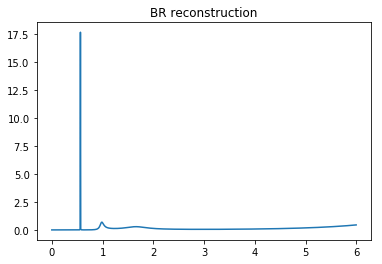

In [7]:
fig = plt.figure()
plt.title('BR reconstruction')
plt.plot(Frequencies,result)

#fig.savefig('BR_reconstruction.pdf')

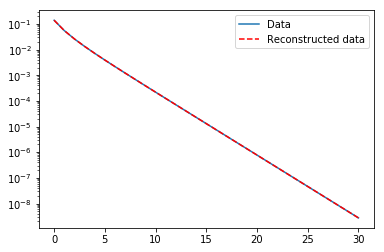

In [8]:
fig = plt.figure()
plt.yscale('log')
plt.plot(DataAverage, label = 'Data')
plt.plot(np.dot(Kernel,result), 'r--', label = 'Reconstructed data')
plt.legend()

#fig.savefig('BR_reconstruction2.pdf')